In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


In [2]:
fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
x_columns = ['v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos',]

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_cat']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_cat']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_cat']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(44751, 11)
(44751,)


In [4]:
valid_y

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

In [3]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled = scaler.fit_transform(test_x)

In [5]:
print(np.max(train_x_scaled), np.min(train_x_scaled))

5.062937084595556 -5.515961514148879


In [6]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11,]),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [ ]:
model.layers

In [ ]:
model.summary()

In [ ]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [7]:
history = model.fit(train_x_scaled, train_y, epochs=20,
                    validation_data=(valid_x_scaled, valid_y))

Epoch 1/20
1399/1399 [==============================] - 2s 1ms/step - loss: 0.9056 - accuracy: 0.6108 - val_loss: 0.7550 - val_accuracy: 0.6753
Epoch 2/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.7049 - accuracy: 0.6927 - val_loss: 0.6779 - val_accuracy: 0.6894
Epoch 3/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.6518 - accuracy: 0.7026 - val_loss: 0.6440 - val_accuracy: 0.7008
Epoch 4/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.6275 - accuracy: 0.7096 - val_loss: 0.6254 - val_accuracy: 0.7062
Epoch 5/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.6132 - accuracy: 0.7144 - val_loss: 0.6130 - val_accuracy: 0.7122
Epoch 6/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.6033 - accuracy: 0.7183 - val_loss: 0.6039 - val_accuracy: 0.7192
Epoch 7/20
1399/1399 [==============================] - 1s 1ms/step - loss: 0.5957 - accuracy: 0.7210 - val_loss: 0.5967 - val_accuracy:

In [8]:
type(history)

keras.callbacks.History

In [9]:
history.history

{'loss': [0.9055534601211548,
  0.7049453258514404,
  0.6518025994300842,
  0.6274932026863098,
  0.613239586353302,
  0.6032715439796448,
  0.5957240462303162,
  0.5896061062812805,
  0.5844876170158386,
  0.5800958275794983,
  0.5761984586715698,
  0.572785496711731,
  0.5697392821311951,
  0.5669621229171753,
  0.5644859075546265,
  0.5621298551559448,
  0.5599613785743713,
  0.5579574108123779,
  0.556101381778717,
  0.554385244846344],
 'accuracy': [0.6108243465423584,
  0.6926772594451904,
  0.7026435136795044,
  0.7096154093742371,
  0.7143974304199219,
  0.7183303236961365,
  0.7209671139717102,
  0.7243860363960266,
  0.7262407541275024,
  0.7270675301551819,
  0.7266653180122375,
  0.7268664240837097,
  0.7277156114578247,
  0.7271122336387634,
  0.7287434935569763,
  0.7297490835189819,
  0.7306652069091797,
  0.7323188185691833,
  0.7334808111190796,
  0.7335925698280334],
 'val_loss': [0.7549945116043091,
  0.6779111623764038,
  0.6440075635910034,
  0.6254367232322693,
  

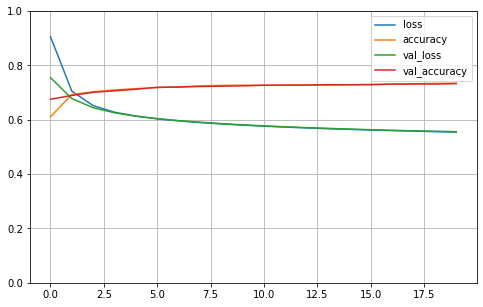

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [12]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.5686219334602356, 0.7342315316200256]